# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': None, 'valid': None, 'test': None}

import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset, DataLoader
# EXPLORATION

# Runnning the file unix command let's us know some info about the image,
# when run on some random images from the dataset I got 800x600 and 600x800 image sizes
# So as not to fall prey to selection bias, the dataset readme states the images are a 
# subset of the Google Landmarks Dataset v2
# Checking on Arxiv (https://arxiv.org/abs/2004.01804) and Github 
# (https://github.com/cvdfoundation/google-landmark) I wasn't able to find info on 
# the image sizes for the dataset

# Running identify *.jpg in the 00.Haleakala_National_Park directory showed sizes of
# 800x600 and 600x800 only (this was after installing ImageMagick)

# identify *.jpg | cut -d' ' -f3
# identify  -format '%w %h\n' 042517e40d998160.jpg 

# If we can show that for all our images the size is either of those mentioned we
# could try to crop to a 600x600 centered image or 512x512 since it could be more efficient
# I think that if the training dataset completely follows this rule we should be fine

# I could test this out using PIL but I would have to open and close every single image to
# get that information, let's just use some bash magic instead :)

# !find "$(cd ..; pwd)" -name "*.jpg"| head -5 | xargs -I {} identify -format "%w %h\n" {}
# 800 600
# 800 600
# 800 600
# 533 800
# 600 800

# Well I pasted the output above and it shows that our hypothesis was incorrect, for now I 
# guess we can resize the images to 512x512 since most images seem to be close to that size
# We'll start with 128x128 to see how well it does, since I worry about my GPU's VRAM limitations

# Let's just quickly see how small of a width and height we have in the dataset

# For width:
# !find "$(cd ..; pwd)" -name "*.jpg" | xargs -I {} identify -format "%w %h\n" {} | sort -nk 1 | head -5
# 225 300
# 228 800
# 275 210
# 286 400
# 293 426

# For height:
# !find "$(cd ..; pwd)" -name "*.jpg" | xargs -I {} identify -format "%w %h\n" {} | sort -nk 2 | head -5
# 800 60
# 800 80
# 299 102
# 800 109
# 800 114

# If our accuracy is too low we could try discarding training images pretty far from an unitary aspect ratio

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

base_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_augmented_transform_1 = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomCrop(256),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_augmented_transform_2 = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomEqualize(),
    transforms.CenterCrop((256,256)),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_augmented_transform_3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset_trainvalid = datasets.ImageFolder('landmark_images/train', transform=base_transform)
dataset_trainvalid_aug_1 = datasets.ImageFolder('landmark_images/train', transform=train_augmented_transform_1)
dataset_trainvalid_aug_2 = datasets.ImageFolder('landmark_images/train', transform=train_augmented_transform_2)
dataset_trainvalid_aug_3 = datasets.ImageFolder('landmark_images/train', transform=train_augmented_transform_3)
dataset_test = datasets.ImageFolder('landmark_images/test', transform=base_transform)

class_names = dataset_trainvalid.classes

num_trainvalid = len(dataset_trainvalid)
indices = list(range(num_trainvalid))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_trainvalid))
train_idx, valid_idx = indices[split:], indices[:split]
train_aug_1_idx = train_idx.copy()
train_aug_2_idx = train_idx.copy()
train_aug_3_idx = train_idx.copy()
train_aug_1_idx = [tidx + num_trainvalid for tidx in train_idx]
train_aug_2_idx = [tidx + num_trainvalid*2 for tidx in train_idx]
train_aug_3_idx = [tidx + num_trainvalid*3 for tidx in train_idx]
# print(num_trainvalid)
# print(train_idx[0:10])
# print(train_aug_1_idx[0:10])
# print(train_aug_2_idx[0:10])
# print(train_aug_3_idx[0:10])

# For use when we merge our traininig datasets
full_train_idx = train_idx + train_aug_1_idx + train_aug_2_idx + train_aug_3_idx # concatenate all our training ranges

train_sampler = SubsetRandomSampler(full_train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Merge our train_valid datasets
dataset_trainvalid_w_aug = ConcatDataset([dataset_trainvalid, dataset_trainvalid_aug_1,
                                          dataset_trainvalid_aug_2, dataset_trainvalid_aug_3])

loaders_scratch['train'] = DataLoader(dataset_trainvalid_w_aug, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)#, shuffle=True) # hmmm this is giving me issues
loaders_scratch['valid'] = DataLoader(dataset_trainvalid, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
loaders_scratch['test'] = DataLoader(dataset_test, batch_size=batch_size, 
    num_workers=num_workers)

# print(len(dataset_trainvalid)) # 4996
# print(len(dataset_trainvalid_w_aug)) # 19984

# print(len(full_train_idx)) # 15988 -> so we should get 16000 / 20 batches == 800 iterator elements
# print(len(valid_idx)) # 999 -> so we should get 1000 / 20 batches == 50 iterator elements

# # Turns out DataLoaders aren't simple iterators so len works:
# print(len(loaders_scratch['train'])) # 800, as calculated above
# print(len(loaders_scratch['valid'])) # 50, as calculated above
# print(len(loaders_scratch['test'])) # 63

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

* I just resized by stretching, sometimes I resized to a "large size", then cropped and finally resized to the desired size just in case. I originally picked 128x128 size since most images seem to be close to a unitary aspect ratio and shouldn't have too many issues due to warping. However, I wasn't getting great results so I tried 512x512 only to run out of VRAM and then settled for 256x256 and it seems to have improved the final result so I kept it.


* I did decide to augment the dataset.
    * However, it was a headache to implement. Apparently, unless I were to implement something like test-time augmentation (https://machinelearningmastery.com/how-to-use-test-time-augmentation-to-improve-model-performance-for-image-classification/) it's not a good idea to run augmentation on the validation and test datasets. I split the training set into training and validation, but found no way to apply transforms to datasets or dataloaders so I went a step backwards and just loaded several identical "starter" training and validation datasets but applied different transforms to them. I then separated the training and validation indices for a random sampler and concatenated them and fed them to the training dataloader. 
    * As for the transforms, I'm using a base transform that applies to the validation and test datasets for resizing, converting to tensors and normalizing image data and another set of transforms that applies only to the training dataset. The latter is a set of 4 different composed transforms that augment the data in different ways. One transform does the same transforms done to the validation and test datasets, another one does a random horizontal flip and and a random rotation, another one crops the image randomly and the last one does image equalization with center cropping. 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

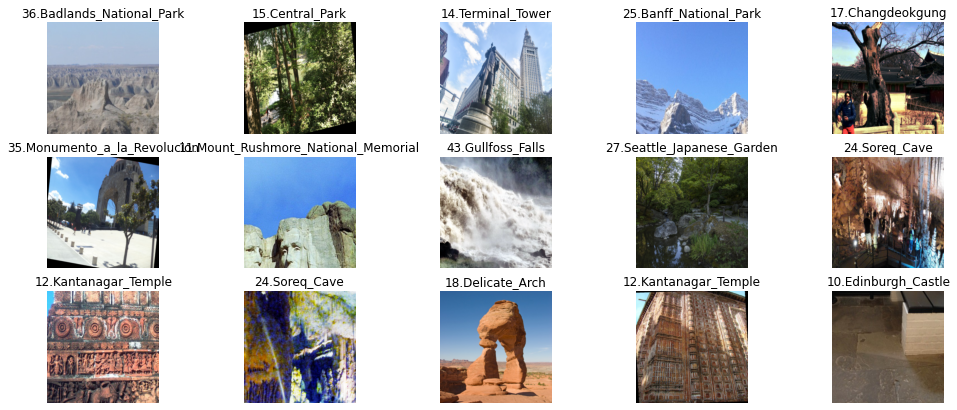

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader
data_iter = iter(loaders_scratch['train'])
images, labels = data_iter.next()

fig = plt.figure(figsize=(17, 7))
rows, columns = 3, 5

for idx, tensor_img in enumerate(images):
    if idx == rows * columns: 
        break
    fig.add_subplot(rows, columns, idx + 1)
    tensor_img = tensor_img / 2 + 0.5 # unnormalize
    plt.imshow(tensor_img.permute(1, 2, 0)) # fix channel order for viz
    plt.axis('off')
    plt.title(class_names[labels[idx]])

### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
import torch.nn as nn

## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
    return optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 16 * 16 -> 500)
#         self.fc1 = nn.Linear(64 * 16 * 16, 500) # For 128x128
#         self.fc1 = nn.Linear(64 * 64 * 64, 500) # For 512x512 
        self.fc1 = nn.Linear(64 * 32 * 32, 500) # For 256x256
        # dropout layer (p=0.9)
        self.dropoutI = nn.Dropout(0.9)        
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 50)
        # dropout layer (p=0.6)
        self.dropoutO = nn.Dropout(0.5)        
        
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
#         x = x.view(-1, 64 * 4 * 4) # Not general enough fixing in next line
        x = x.view(x.size(0), -1)
        # add dropout layer
        x = self.dropoutI(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropoutO(x)
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

As per the class notes, after going over a few resources it was recommended we use 2 or 3 convolutional layers when doing image classification tasks so I opted for that going from depth 3 -> 6 -> 32 -> 64. I chose a kernel of size 5x5 since our images were bigger than those seen in class which used a 3x3 kernel. After each convolution layer I used a MaxPool layer, the last one then went to a 500 neuron fully connected layer and then used another fully connected layer to go to our 50 class output. I was having issues with overfitting so I set two dropouts, the one for the first fully connected layer to 90% and the final one to 50%, I chose these values from the ranges suggested in the second page of the 2014 paper (https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf). Even though I read some worrying discusions when using dropout on CNNs, they seemed to help reduce overfitting due to the validation loss behavior I saw

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
#             print(len(output), len(target))
            # calculate the batch loss
#             try:
#             from IPython import embed; embed()
            loss = criterion(output, target)
#             except:
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
#             train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
#             valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
## TODO: implement a weight initialization strategy
def custom_weight_init(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear):
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0, 0.03)

i

def custom_weight_init_okish(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def custom_weight_init_gives_nans(m):
    classname = m.__class__.__name__
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)
        
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.835061 	Validation Loss: 3.618666
Validation loss decreased (inf --> 3.618666).  Saving model ...
Epoch: 2 	Training Loss: 3.660601 	Validation Loss: 3.490424
Validation loss decreased (3.618666 --> 3.490424).  Saving model ...
Epoch: 3 	Training Loss: 3.547804 	Validation Loss: 3.389161
Validation loss decreased (3.490424 --> 3.389161).  Saving model ...
Epoch: 4 	Training Loss: 3.460430 	Validation Loss: 3.317895
Validation loss decreased (3.389161 --> 3.317895).  Saving model ...
Epoch: 5 	Training Loss: 3.369823 	Validation Loss: 3.211038
Validation loss decreased (3.317895 --> 3.211038).  Saving model ...
Epoch: 6 	Training Loss: 3.329008 	Validation Loss: 3.170897
Validation loss decreased (3.211038 --> 3.170897).  Saving model ...
Epoch: 7 	Training Loss: 3.266185 	Validation Loss: 3.072923
Validation loss decreased (3.170897 --> 3.072923).  Saving model ...
Epoch: 8 	Training Loss: 3.210860 	Validation Loss: 3.053696
Validation loss decreased (3.07292

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100 

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.866254 	Validation Loss: 3.785706
Validation loss decreased (inf --> 3.785706).  Saving model ...
Epoch: 2 	Training Loss: 3.782965 	Validation Loss: 3.709032
Validation loss decreased (3.785706 --> 3.709032).  Saving model ...
Epoch: 3 	Training Loss: 3.747616 	Validation Loss: 3.637301
Validation loss decreased (3.709032 --> 3.637301).  Saving model ...
Epoch: 4 	Training Loss: 3.704525 	Validation Loss: 3.583922
Validation loss decreased (3.637301 --> 3.583922).  Saving model ...
Epoch: 5 	Training Loss: 3.647384 	Validation Loss: 3.563229
Validation loss decreased (3.583922 --> 3.563229).  Saving model ...
Epoch: 6 	Training Loss: 3.617392 	Validation Loss: 3.526934
Validation loss decreased (3.563229 --> 3.526934).  Saving model ...
Epoch: 7 	Training Loss: 3.571193 	Validation Loss: 3.465133
Validation loss decreased (3.526934 --> 3.465133).  Saving model ...
Epoch: 8 	Training Loss: 3.532444 	Validation Loss: 3.406016
Validation loss decreased (3.46513

Epoch: 91 	Training Loss: 2.529666 	Validation Loss: 2.542755
Epoch: 92 	Training Loss: 2.514759 	Validation Loss: 2.565113
Epoch: 93 	Training Loss: 2.517782 	Validation Loss: 2.465772
Validation loss decreased (2.504681 --> 2.465772).  Saving model ...
Epoch: 94 	Training Loss: 2.495047 	Validation Loss: 2.523139
Epoch: 95 	Training Loss: 2.498724 	Validation Loss: 2.486299
Epoch: 96 	Training Loss: 2.486549 	Validation Loss: 2.485047
Epoch: 97 	Training Loss: 2.479719 	Validation Loss: 2.431002
Validation loss decreased (2.465772 --> 2.431002).  Saving model ...
Epoch: 98 	Training Loss: 2.498757 	Validation Loss: 2.573833
Epoch: 99 	Training Loss: 2.482409 	Validation Loss: 2.487115
Epoch: 100 	Training Loss: 2.477459 	Validation Loss: 2.492712


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.277630


Test Accuracy: 43% (538/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [10]:
loaders_transfer = {'train': None, 'valid': None, 'test': None}

import numpy as np
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset, DataLoader

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

base_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_augmented_transform_1 = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_augmented_transform_2 = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomEqualize(),
    transforms.CenterCrop((224,224)),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_augmented_transform_3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataset_trainvalid = datasets.ImageFolder('landmark_images/train', transform=base_transform)
dataset_trainvalid_aug_1 = datasets.ImageFolder('landmark_images/train', transform=train_augmented_transform_1)
dataset_trainvalid_aug_2 = datasets.ImageFolder('landmark_images/train', transform=train_augmented_transform_2)
dataset_trainvalid_aug_3 = datasets.ImageFolder('landmark_images/train', transform=train_augmented_transform_3)
dataset_test = datasets.ImageFolder('landmark_images/test', transform=base_transform)

class_names = dataset_trainvalid.classes

num_trainvalid = len(dataset_trainvalid)
indices = list(range(num_trainvalid))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_trainvalid))
train_idx, valid_idx = indices[split:], indices[:split]
train_aug_1_idx = train_idx.copy()
train_aug_2_idx = train_idx.copy()
train_aug_3_idx = train_idx.copy()
train_aug_1_idx = [tidx + num_trainvalid for tidx in train_idx]
train_aug_2_idx = [tidx + num_trainvalid*2 for tidx in train_idx]
train_aug_3_idx = [tidx + num_trainvalid*3 for tidx in train_idx]

# For use when we merge our traininig datasets
full_train_idx = train_idx + train_aug_1_idx + train_aug_2_idx + train_aug_3_idx # concatenate all our training ranges

train_sampler = SubsetRandomSampler(full_train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Merge our train_valid datasets
dataset_trainvalid_w_aug = ConcatDataset([dataset_trainvalid, dataset_trainvalid_aug_1,
                                          dataset_trainvalid_aug_2, dataset_trainvalid_aug_3])

loaders_transfer['train'] = DataLoader(dataset_trainvalid_w_aug, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)#, shuffle=True) # hmmm this is giving me issues
loaders_transfer['valid'] = DataLoader(dataset_trainvalid, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
loaders_transfer['test'] = DataLoader(dataset_test, batch_size=batch_size, 
    num_workers=num_workers)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [11]:
## TODO: select loss function
import torch.nn as nn

criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
#     return torch.optim.SGD(model.parameters(), lr=0.05)


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [12]:
## TODO: Specify model architecture
import torchvision
model_transfer = torchvision.models.vgg16(pretrained=True)
for param in model_transfer.features.parameters():
    param.requires_grad = False
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(class_names))
model_transfer.classifier[6] = last_layer
use_cuda = torch.cuda.is_available()


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
I used a pretrained vgg16 network since it was shown in class that it works pretty well for image classification tasks. I have yet to try other pretrained networks such as vgg19 which might provide better results. While looking for more information, I found a visual comparison of multiple pretrained networks in the MathWorks documentation (https://www.mathworks.com/help/deeplearning/ug/pretrained-convolutional-neural-networks.html). Based on those diagrams, if my main concern was accuracy I would opt to try Inception-Resnet-v2 or NASNet-Large. However if I also valued prediction time then ResNet-101 would be a good candidate.

I proceded to fix the trained parameters for the feature section of the network and then swapped out the last fully connected layer by one that mapped to our 50 classes from the previous inputs it held. This would allow us to only train the classifier layers (fully connnected layers) and get a decent result for our purposes.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [13]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

optimizer = get_optimizer_transfer(model_transfer)
criterion = criterion_transfer
valid_loss_min = np.Inf 

# number of epochs to train the model
n_epochs = 45
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    # model by default is set to train
    model_transfer.train()
    for batch_idx, (data, target) in enumerate(loaders_transfer['train']):
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
#         train_loss += loss.item()
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        

    ######################    
    # validate the model #
    ######################
    # set the model to evaluation mode
    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders_transfer['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        ## TODO: update average validation loss 

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model_transfer(data)
        # calculate the batch loss
        loss = criterion(output, target)
        valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
        
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, 
        train_loss,
        valid_loss
        ))            
    
    if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model_transfer.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
            
            
#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.914460 	Validation Loss: 1.910681
Validation loss decreased (inf --> 1.910681).  Saving model ...
Epoch: 2 	Training Loss: 2.552898 	Validation Loss: 1.793371
Validation loss decreased (1.910681 --> 1.793371).  Saving model ...
Epoch: 3 	Training Loss: 2.348590 	Validation Loss: 1.807270
Epoch: 4 	Training Loss: 2.234905 	Validation Loss: 1.640899
Validation loss decreased (1.793371 --> 1.640899).  Saving model ...
Epoch: 5 	Training Loss: 2.141769 	Validation Loss: 1.774957
Epoch: 6 	Training Loss: 2.195350 	Validation Loss: 1.606448
Validation loss decreased (1.640899 --> 1.606448).  Saving model ...
Epoch: 7 	Training Loss: 2.116204 	Validation Loss: 1.739834
Epoch: 8 	Training Loss: 2.090181 	Validation Loss: 1.755376
Epoch: 9 	Training Loss: 2.099891 	Validation Loss: 1.697723
Epoch: 10 	Training Loss: 2.078133 	Validation Loss: 1.693741
Epoch: 11 	Training Loss: 2.042795 	Validation Loss: 1.791915
Epoch: 12 	Training Loss: 2.021789 	Validation Loss: 1.7

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [14]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.371725


Test Accuracy: 65% (815/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [15]:
import cv2
from PIL import Image
import torchvision
from torchvision import transforms
import torch.nn as nn

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
model_transfer = torchvision.models.vgg16(pretrained=True)
n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(class_names))
model_transfer.classifier[6] = last_layer

model_transfer.load_state_dict(torch.load('model_transfer.pt'))

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    res = []
    with Image.open(img_path) as im:
        model_transfer.eval()
        transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        tensor_im = transform(im)
        # forward pass: compute predicted outputs by passing inputs to the model
        # Added some magic since pytorch expects a batch of images as input
        output = model_transfer(tensor_im[None, ...]).float()
        prob_to_pos = {output.data[0,pos]:pos for pos in range(50)}
        prob_to_pos_items = prob_to_pos.items()
        sorted_prob_to_pos_items = sorted(prob_to_pos_items, reverse=True)
        for idx, (prob, pos) in enumerate(sorted_prob_to_pos_items):
            if idx == k:
                break
#             print('At place k=', idx + 1, ' we have a prediction of ',classes[pos])
            res.append(class_names[pos].split('.')[1].replace('_', ' '))
    return res


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Forth Bridge',
 'Golden Gate Bridge',
 'Dead Sea',
 'Brooklyn Bridge',
 'Sydney Harbour Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

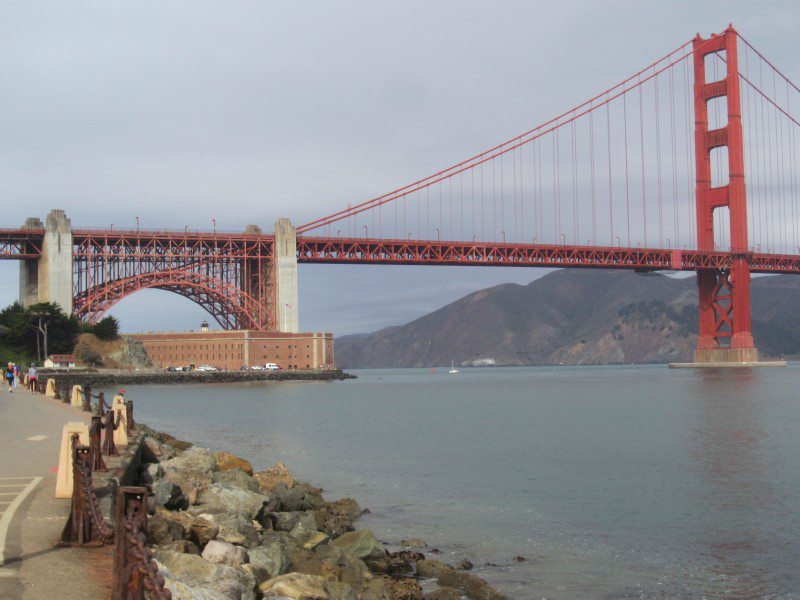

Is this a picture of the Forth Bridge, Golden Gate Bridge, Dead Sea ?


In [16]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    with Image.open(img_path) as im:
        display(im)
        print('Is this a picture of the', ", ".join(predicted_landmarks), "?")
    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

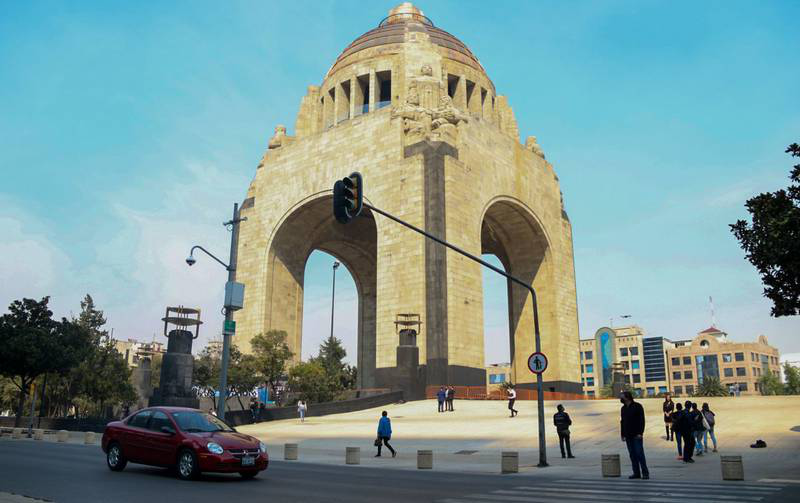

Is this a picture of the Monumento a la Revolucion, Ljubljana Castle, Gateway of India ?


In [17]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

# I'm currently staying in Mexico City and I've seen this guy personally several times :)
suggest_locations('other_images/mon_rev_from_google.jpg')

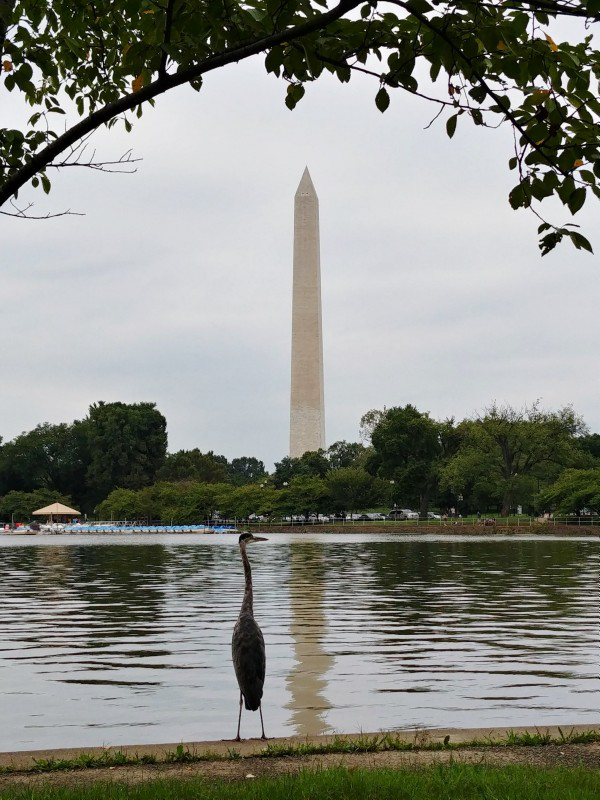

Is this a picture of the Washington Monument, Central Park, Stockholm City Hall ?


In [18]:
suggest_locations('landmark_images/test/31.Washington_Monument/2885526bd4778fa5.jpg')


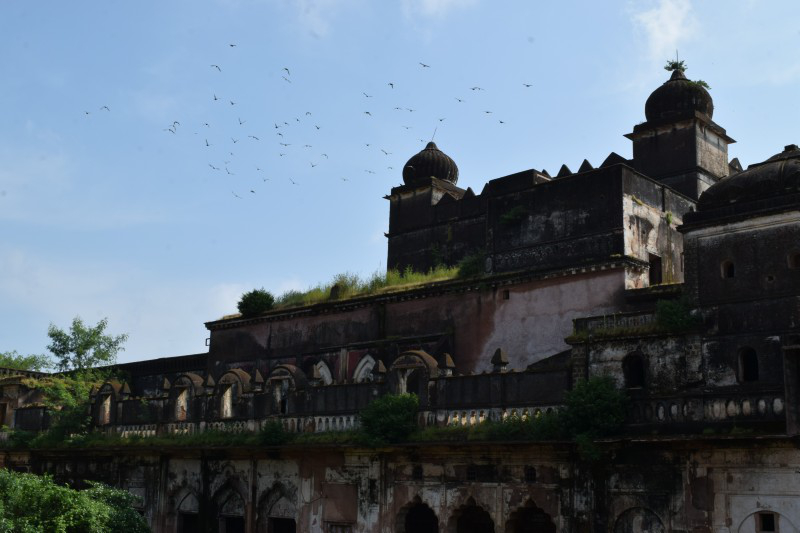

Is this a picture of the Taj Mahal, Stockholm City Hall, Gateway of India ?


In [19]:
suggest_locations('landmark_images/test/21.Taj_Mahal/7e07dd4e04247a52.jpg')


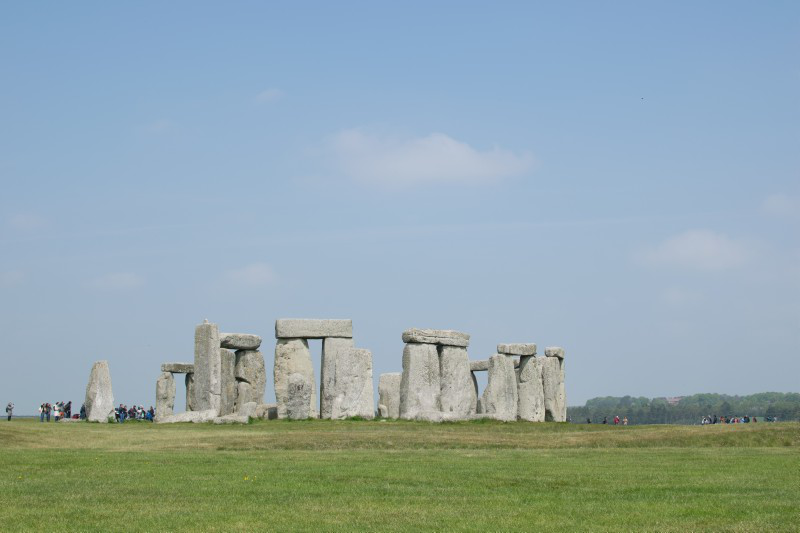

Is this a picture of the Stonehenge, Whitby Abbey, Badlands National Park ?


In [20]:
suggest_locations('landmark_images/test/07.Stonehenge/279d4a45fb6c8aab.jpg')

Answer: 
* The output is better than I expected! I fed it one image I got from doing a search of the "Monumento a la Revolucion", which I have visited often and it worked perfectly. I even checked if it was part of the training dataset and it wasn't, so that makes it even better.
* Possible things to improve
    * Run this for more epochs than the ones I tried, the validation loss isn't going up that much so I could have trained for longer or tweaked some parameters so it would allow me to
    * Add more augmented training datasets using other transforms or less random instructions and more "manual" ones so our training data is far larger
    * I'm currently using Adam with the commonly "suggested" parameters, but I didn't really explore tweaking these values
    * I could also try using a different optimizer such as SGD with and without momentum with different parameters